In [1]:
import matplotlib.pyplot as plt
import rasterio.plot

In [2]:
plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size
%config InlineBackend.figure_format = 'retina'

## Handler

In [3]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point

precision = 5 # precision of input coordinates, 5dec~=1.1m

class GISHandler:
    """A class to handle GIS raster data and optimizer points."""
        
    def __init__(self, conditions, conflicts, scope):
        """Initializes handler by creating a GeoDataFrame to store point measurement data and a dictionary of loaded raster files."""
        self.conditions = {}
        self.conflicts = {}
        self.points = gpd.GeoDataFrame(columns=['x', 'y', 'ok-conditions', 'ok-scope', 'ok-conflicts', 'result', 'geometry'], geometry='geometry')
        
        self.scope = gpd.read_file(scope)
    
        for key, src in conditions.items():
            if key in self.conditions:
                print('raster {} already loaded!'.format(key))
            else:
                self.conditions[key] = rasterio.open(src)
                
        for key, src in conflicts.items():
            if key in self.conflicts:
                print('vector {} already loaded!'.format(key))
            else:
                self.conflicts[key] = gpd.read_file(src)
                
        self.extent = self.extent()
    
    def query(self, y, x):
        """Gets condition data for a specified geography location (lon/lat), stores it in the GeoDataFrame, and returns the row."""
        x, y = self.coordinate(x, y)
                                    
        #if not self.points.loc[(self.points.x==x) & (self.points.y==y)].empty:
        #    print('point exists, returning original data')
        #    return self.points.loc[(self.points.x==x) & (self.points.y==y)]
        
        point = Point(x, y)
        conditions = {'x': x, 'y': y, 'ok-conditions': True, 'ok-scope': True, 'ok-conflicts': True, 'geometry': point}
        
        # check if point is offshore in desired scope
        for polygon in self.scope['geometry']:
            if point.intersects(polygon):
                conditions['ok-scope'] = True
            else:
                conditions['ok-scope'] = False
        
        # check if point intersects with any of the conflicts loaded as vectors
        for key, vector in self.conflicts.items():
            for polygon in vector['geometry']:
                if point.intersects(polygon):
                    conditions['ok-conflicts'] = False
        
        # check if point exists for all condition datasets, and pull condition data for point
        for key, raster in self.conditions.items():
            index = raster.index(x, y)
            try:
                 conditions[key] = raster.read(1)[index] # yes, by default this only reads the first band, but this is probably okay
            except IndexError as error:
                print('failed to read {} raster: {}'.format(key, error))
            if conditions[key] <= -1000: # yes, this assumes that zero is not a valid value. this is true for our current rasters, but isn't necessarily correct
                conditions['ok-conditions'] = False
        
        self.points = self.points.append(conditions, ignore_index=True)
        return self.points.iloc[-1:]
    
    def record(self, y, x, value):
        """Records a computed value from the optimizer to a geographic point, returns row recorded to."""
        x, y = self.coordinate(x, y)
        
        if not self.points.loc[(self.points.x==x) & (self.points.y==y)].empty:
            self.points.loc[(self.points.x==x) & (self.points.y==y), 'result'] = value
            return self.points.loc[(self.points.x==x) & (self.points.y==y)]
        
        conditions = {'x': x, 'y': y, 'geometry': Point(x, y), 'result': value}
        self.points = self.points.append(conditions, ignore_index=True)
        return self.points.iloc[-1:]
    
    def save(self, name):
        self.points.to_file(name, driver='GeoJSON')
        
    def load(self, name):
        self.points = gpd.read_file(name)
        
    def coordinate(self, x, y):
        """Rounds coordinates to given precision to prevent uneccessary duplication, in the future could handle projections."""
        return round(x, precision), round(y, precision)
    
    def extent(self):
        """Calculates largest square extent that includes data from all loaded rasters."""
        
        extent = [-180, 180, -90, 90] # format: [W, E, S, N]
        for src in self.conditions.values():
            extent = [max(extent[0], src.bounds[0]), min(extent[1], src.bounds[2]), max(extent[2], src.bounds[1]), min(extent[3], src.bounds[3])]
            
        return extent

## Example

In [4]:
conditions = {'current [m/s]': 'data/Surface Current (m-s).tif',
           'oxygen [mg/l]': 'data/Surface Oxygen (mg-l).tif',
           'salinity [PSU]': 'data/Surface Salinity (PSU).tif',
           'temperature [°C]': 'data/Surface Temperature (C).tif',
           'period [s]': 'data/Wave Energy Period (s).tif',
           'power [kW/m]': 'data/Wave Power Density (kW-m).tif',
           'height [m]': 'data/Wave Significant Height (m).tif',
           'distance to port [m]': 'data/Distance to Port (m).tif',
           'distance to shore [m]': 'data/Distance to Shore (m).tif',
           'bathymetry [m]': 'data/Bathymetry (m).tif'}

conflicts = {'block island': 'data/Block Island Renewable Energy Zone.geojson',
           'torpex': 'data/Cape Cod TORPEX.geojson',
           'danger zones': 'data/Danger Zones and Restricted Areas.geojson',
           'ma wind': 'data/MA Wind Energy Areas.geojson',
           'wind lease': 'data/Potential Wind Lease Areas.geojson',
           'shipping': 'data/Shipping Lanes.geojson',
           'submarine': 'data/Submarine Transit Lanes.geojson',
           'wind planning': 'data/Wind Planning Areas.geojson'}

waters = "data/Northeast State and Federal Waters.geojson"

handler = GISHandler(conditions, conflicts, waters)

In [5]:
print('Extent: W', handler.extent[0], 'E', handler.extent[1], 'S', handler.extent[2], 'N', handler.extent[3])

Extent: W -75.105000333 E -65.695000333 S 38.269566058 N 45.195711428


In [6]:
handler.query(42.203, -70.154)

/usr/local/anaconda3/envs/geo-venv/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,x,y,ok-conditions,ok-scope,ok-conflicts,result,geometry,bathymetry [m],current [m/s],distance to port [m],distance to shore [m],height [m],oxygen [mg/l],period [s],power [kW/m],salinity [PSU],temperature [°C]
0,-70.154,42.203,True,True,True,NaN,POINT (-70.15400 42.20300),-41.799999,0.123721,76157.726562,12010.412109,0.88,9.504469,5.71,3.5,31.597025,10.291017


In [7]:
handler.record(40.932999, -72, 10)

/usr/local/anaconda3/envs/geo-venv/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,x,y,ok-conditions,ok-scope,ok-conflicts,result,geometry,bathymetry [m],current [m/s],distance to port [m],distance to shore [m],height [m],oxygen [mg/l],period [s],power [kW/m],salinity [PSU],temperature [°C]
1,-72.0,40.933,NaN,NaN,NaN,10.0,POINT (-72.00000 40.93300),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
handler.query(41.549, -69.83)

/usr/local/anaconda3/envs/geo-venv/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,x,y,ok-conditions,ok-scope,ok-conflicts,result,geometry,bathymetry [m],current [m/s],distance to port [m],distance to shore [m],height [m],oxygen [mg/l],period [s],power [kW/m],salinity [PSU],temperature [°C]
2,-69.83,41.549,True,True,True,NaN,POINT (-69.83000 41.54900),-20.299999,0.10263,112477.773438,10770.329102,1.04,9.440255,5.73,4.5,31.744743,10.074166


In [9]:
handler.query(40, -71.5)

/usr/local/anaconda3/envs/geo-venv/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,x,y,ok-conditions,ok-scope,ok-conflicts,result,geometry,bathymetry [m],current [m/s],distance to port [m],distance to shore [m],height [m],oxygen [mg/l],period [s],power [kW/m],salinity [PSU],temperature [°C]
3,-71.5,40.0,True,True,False,NaN,POINT (-71.50000 40.00000),-101.0,0.157585,169589.203125,116847.125,0.0,8.863604,0.0,0.0,33.422619,14.039436


In [10]:
handler.query(43, -72)

/usr/local/anaconda3/envs/geo-venv/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,x,y,ok-conditions,ok-scope,ok-conflicts,result,geometry,bathymetry [m],current [m/s],distance to port [m],distance to shore [m],height [m],oxygen [mg/l],period [s],power [kW/m],salinity [PSU],temperature [°C]
4,-72.0,43.0,False,False,True,NaN,POINT (-72.00000 43.00000),0.0,0.0,102647.453125,31400.636719,0.0,-3.402823e+38,0.0,0.0,NaN,0.0


In [11]:
handler.save('saved.geojson')

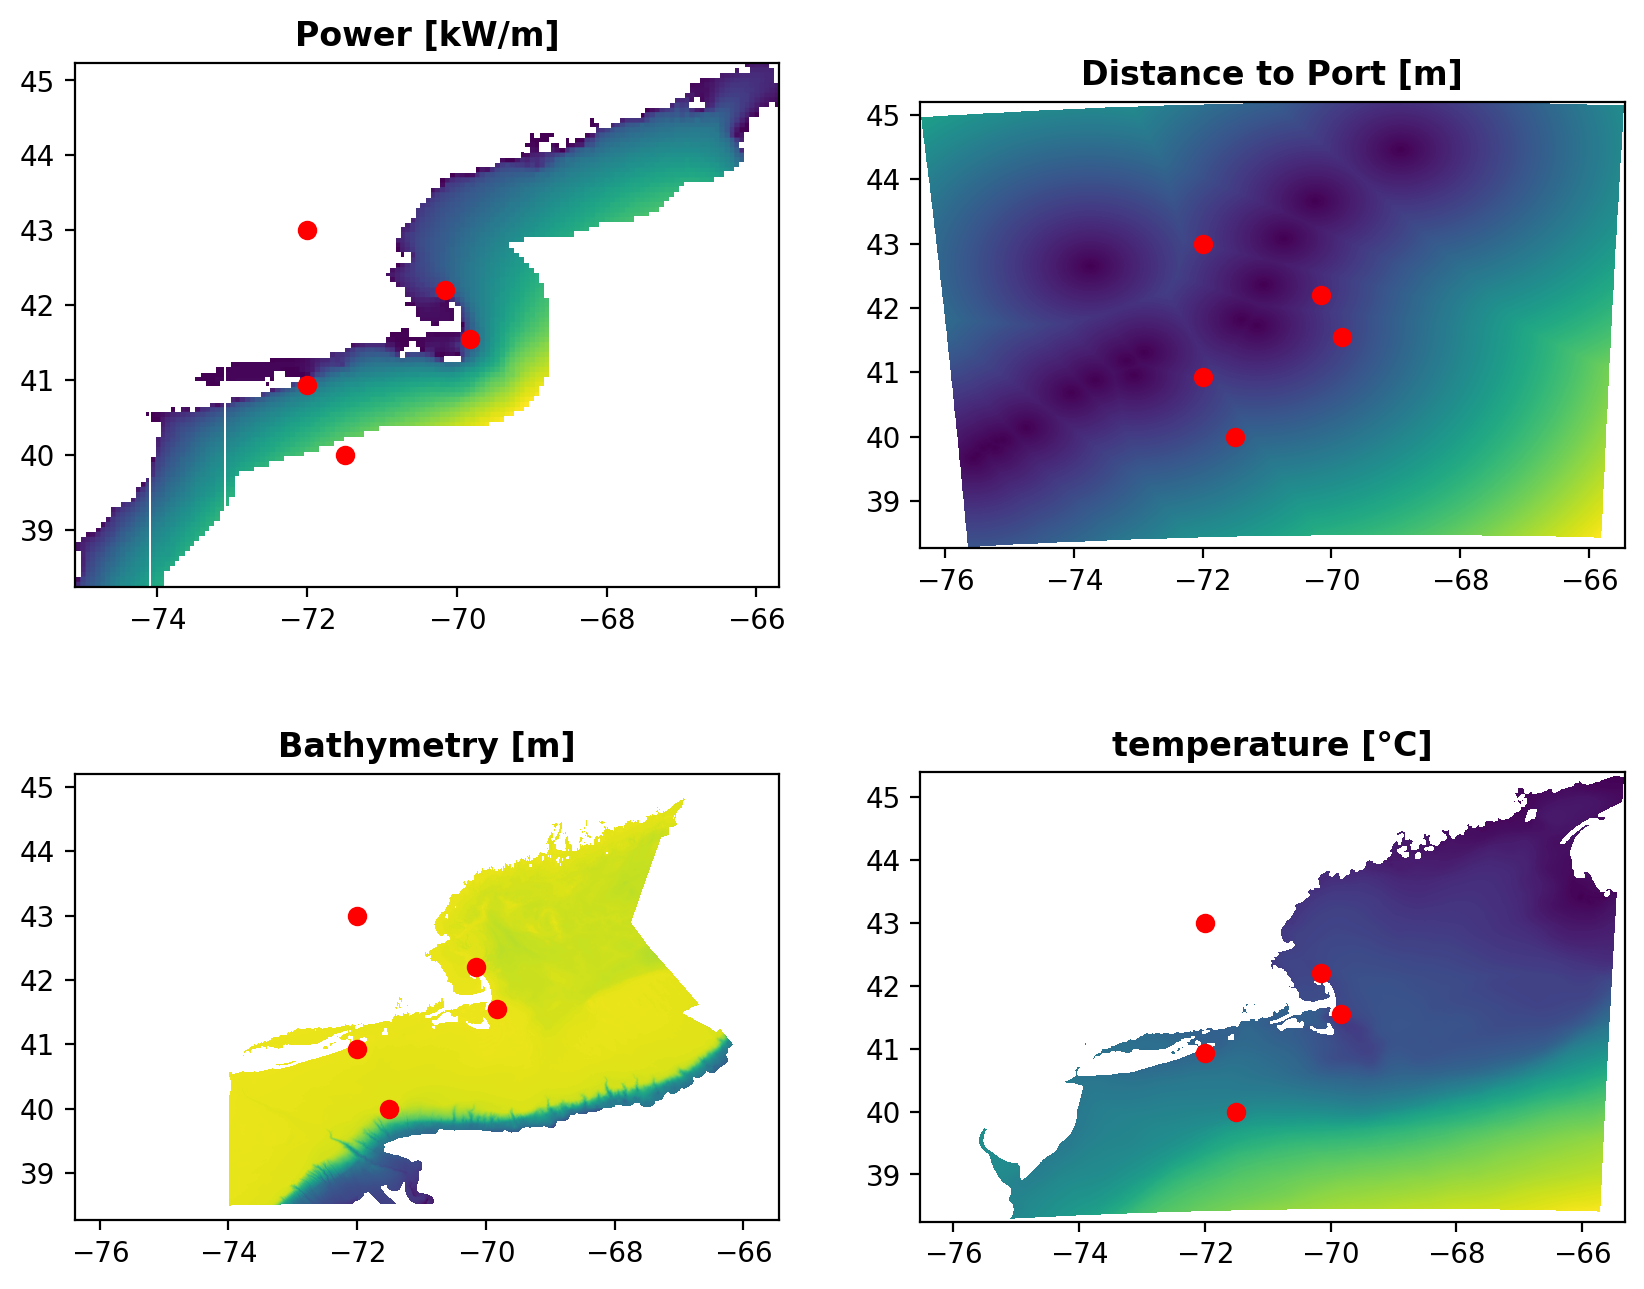

In [12]:
fig, ax = plt.subplots(2, 2)
rasterio.plot.show(handler.conditions['power [kW/m]'], ax=ax[0,0], title='Power [kW/m]')
rasterio.plot.show(handler.conditions['distance to port [m]'], ax=ax[0,1], title='Distance to Port [m]')
rasterio.plot.show(handler.conditions['bathymetry [m]'], ax=ax[1,0], title='Bathymetry [m]')
rasterio.plot.show(handler.conditions['temperature [°C]'], ax=ax[1,1], title='temperature [°C]')

for i in ax:
    for j in i:
        handler.points.plot(ax=j, color='red')

<AxesSubplot:>

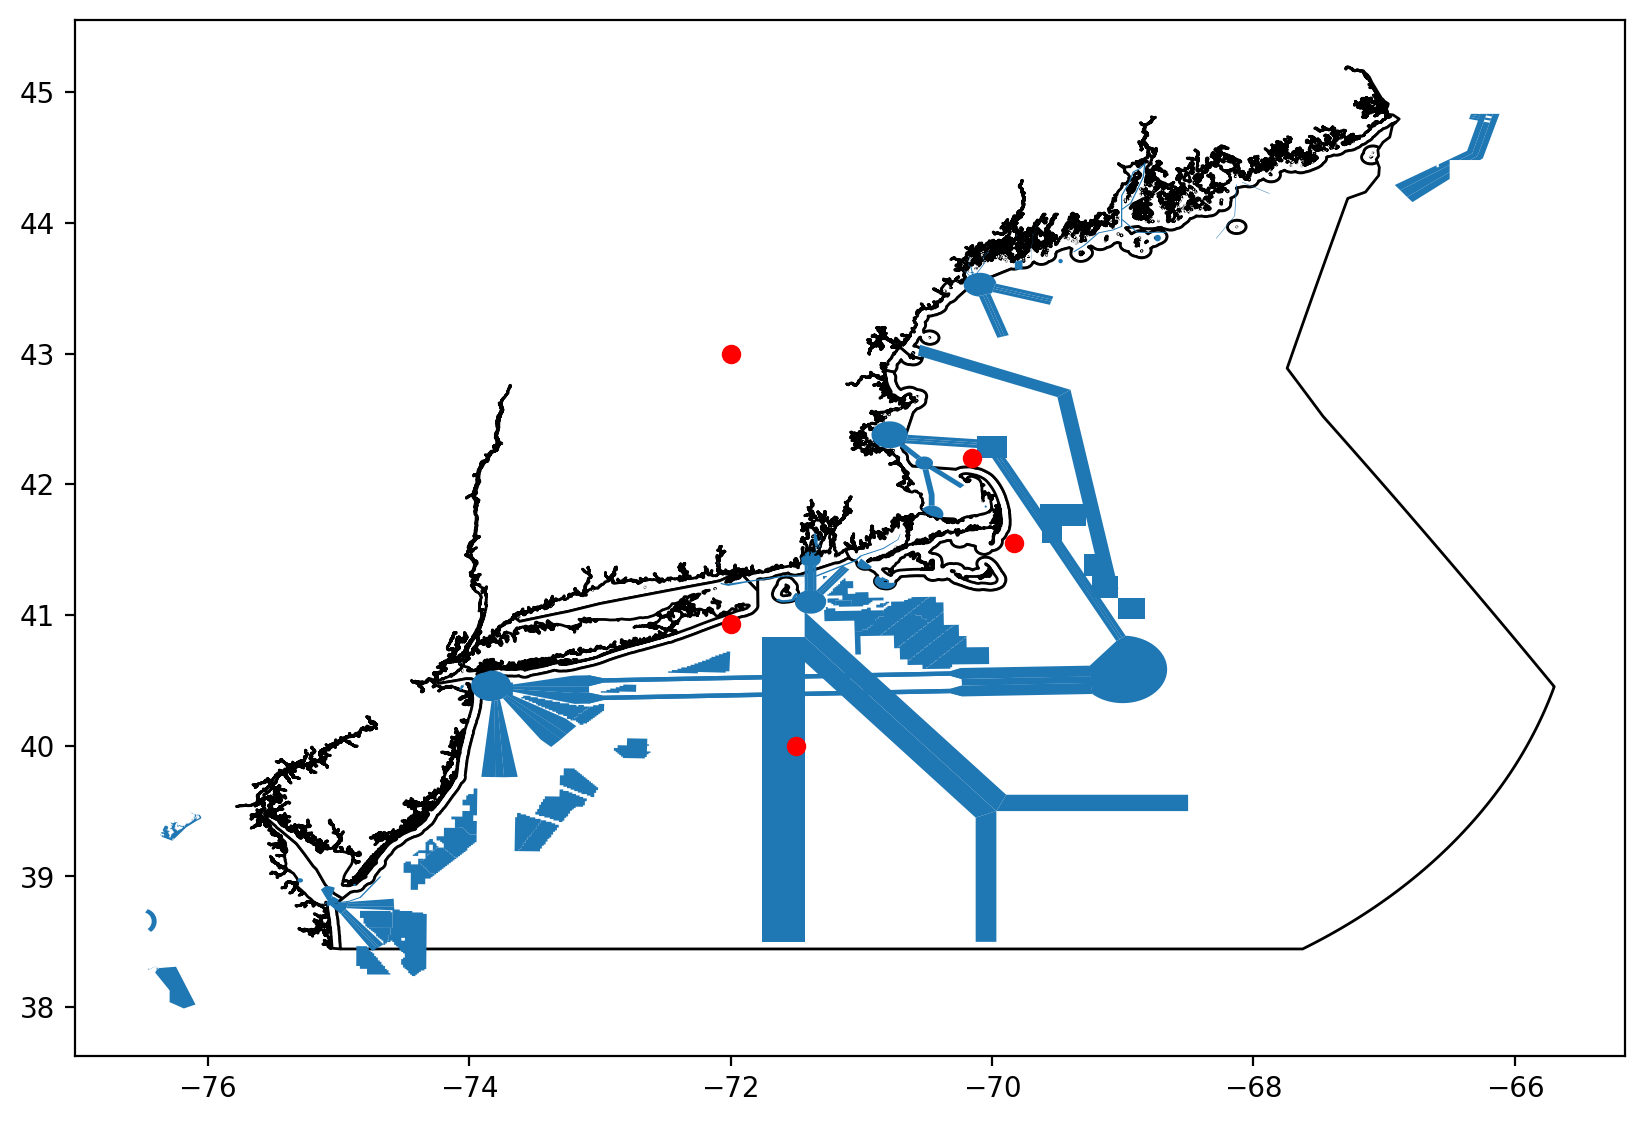

In [13]:
fig, ax = plt.subplots()
handler.scope.plot(edgecolor='black', color='white', ax=ax)
for gdf in handler.conflicts.values():
    gdf.plot(ax=ax)
handler.points.plot(ax=ax, color='red')

In [14]:
handler.points

,x,y,ok-conditions,ok-scope,ok-conflicts,result,geometry,bathymetry [m],current [m/s],distance to port [m],distance to shore [m],height [m],oxygen [mg/l],period [s],power [kW/m],salinity [PSU],temperature [°C]
0,-70.154,42.203,True,True,True,NaN,POINT (-70.15400 42.20300),-41.799999,0.123721,76157.726562,12010.412109,0.88,9.504469e+00,5.71,3.5,31.597025,10.291017
1,-72.000,40.933,NaN,NaN,NaN,10.0,POINT (-72.00000 40.93300),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-69.830,41.549,True,True,True,NaN,POINT (-69.83000 41.54900),-20.299999,0.102630,112477.773438,10770.329102,1.04,9.440255e+00,5.73,4.5,31.744743,10.074166
3,-71.500,40.000,True,True,False,NaN,POINT (-71.50000 40.00000),-101.000000,0.157585,169589.203125,116847.125000,0.00,8.863604e+00,0.00,0.0,33.422619,14.039436
4,-72.000,43.000,False,False,True,NaN,POINT (-72.00000 43.00000),0.000000,0.000000,102647.453125,31400.636719,0.00,-3.402823e+38,0.00,0.0,NaN,0.000000


## 2/27 Notes
- create traffic set at one standard deviation
- consistent order (lon, lat)
- on/off shore flag, split up flags by category (offshore, wind, transportation, military, fisheries)
- create grid and return points, create based on x, y, min, max, resolution, check literature for units
- write mapping tool section and contribute to results section, review introduction (by friday or saturday)
- several mapping figures of data, conflicts, grid for brute force, and final optimal brute force, and maybe optimizer result